In [1]:
import sys
import os
import time
import datetime
from qudi.util.network import netobtain
import matplotlib.pyplot as plt
import importlib
sys.path.append('../xq1i')
import libxq1i
importlib.reload(libxq1i)

confocal2 = libxq1i.xq1i(pulsed_master_logic, pulsed_measurement_logic, sequence_generator_logic)

Go to POI POI_8 ...
Position and counts at peak after refocus: (9.301, 45.763, -5.611) µm,  σ= (0.180, 0.316, 0.756) µm, peak cnts: 4.47E+04
Start measurements for orientation 5 ...


 ... rabi:   0%|          | 0/10000.0 [00:00<?, ?sweeps/s]

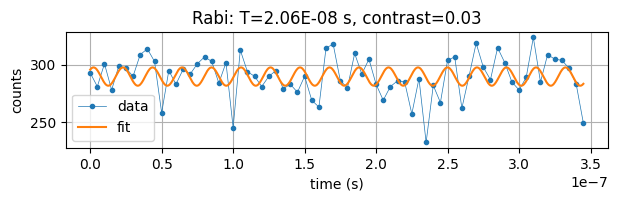

 ... pulsedODMR:   0%|          | 0/10000000.0 [00:00<?, ?sweeps/s]

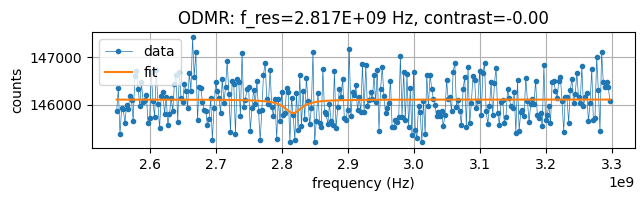

All POIs measured successfully.


In [4]:
# Create folder
run_folder = f"characterization_run_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"
os.makedirs(run_folder, exist_ok=True)

# Create/open a summary text file inside that folder
summary_file_path = os.path.join(run_folder, "measurements_summary.txt")
outputFile = open(summary_file_path, 'w')


orientation_properties = {
    1: {'res_freq': 2.605e9, 'freq_range': [2580.0e6, 1.0e6, 40],  'rabi_period': 2.73e-7},
    2: {'res_freq': 2.665e9, 'freq_range': [2640.0e6, 1.0e6, 40],  'rabi_period': 5.06e-7},
    3: {'res_freq': 2.840e9, 'freq_range': [2820.0e6, 1.0e6, 40], 'rabi_period': 2.93e-7},
    4: {'res_freq': 2.887e9, 'freq_range': [2870.0e6, 1.0e6, 40], 'rabi_period': 2.05e-7},
    5: {'res_freq': 2.900e9, 'freq_range': [2550.0e6, 2.5e6, 300], 'rabi_period': 2.05e-7},
}

poi_list = [
    #{'poi': 'POI_40', 'orientations': [2,4]},
    #{'poi': 'POI_54', 'orientations': [3,4]},
    #{'poi': 'POI_61', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_1', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_2', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_3', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_4', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_5', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_6', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_7', 'orientations': [1,2,3,4]},
    {'poi': 'POI_8', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_9', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_10', 'orientations': [1,2,3,4]},
    #{'poi': 'POI_8', 'orientations': [5]},
]

# Clear pulse generator
pulsed_master_logic.clear_pulse_generator()
time.sleep(1)

# Header for summary file
outputFile.write("POI\tOrientation\tcountsStart\tcountsEnd\t"
                 "res_freq(Hz)\todmr_contrast\t"
                 "rabi_period(s)\trabi_contrast\n")

for entry in poi_list:
    currPoi = entry['poi']
    print(f"Go to POI {currPoi} ...")

    # Disable refocus/tracking, move to POI, then re-enable
    poi_manager_logic.toggle_periodic_refocus(False)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    poi_manager_logic.go_to_poi(currPoi)
    poi_manager_logic.set_active_poi(currPoi)
    poi_manager_logic.toggle_periodic_refocus(True)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)

    print("Position and counts at peak after refocus:", scanner_gui.optimizer_dockwidget.result_label.text())
    for orientation in entry['orientations']:
        print(f"Start measurements for orientation {orientation} ...")
        countsStart = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        # -------------------------
        # 1) Rabi Measurement (Sine Fit)
        # -------------------------
        confocal2.generate_params['microwave_frequency'] = orientation_properties[orientation]['res_freq']
        # If there's a known special shift for certain POIs:
        if (currPoi == 'POI_58') and (orientation == 1):
            confocal2.generate_params['microwave_frequency'] += 14e6

        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        #confocal2.rabi_sweeps = 1e6
        confocal2.rabi_sweeps = 1e4

        rabi_label = f"{currPoi}_ornt_{orientation}_Rabi"
        confocal2.do_rabi(rabi_label, isSlow=True)

        # Fit with 'Sine'
        result_rabi = netobtain(pulsed_measurement_logic.do_fit('Sine'))
        
        # -- extract relevant fit parameters
        rabi_amplitude = result_rabi.params['amplitude'].value
        rabi_offset = result_rabi.params['offset'].value
        rabi_freq = result_rabi.params['frequency'].value

        rabi_amplitude_std = result_rabi.params['amplitude'].stderr
        rabi_offset_std = result_rabi.params['offset'].stderr
        rabi_freq_std = result_rabi.params['frequency'].stderr

        rabi_rsquared = result_rabi.rsquared
        rabi_chi_square = result_rabi.chisqr
        rabi_reduced_chi_square = result_rabi.redchi
        rabi_aic = result_rabi.aic
        rabi_aic = result_rabi.bic

        # Rabi period
        rabi_period = 1.0 / rabi_freq
        # Rabi contrast = amplitude / offset
        rabi_contrast = rabi_amplitude / rabi_offset if rabi_offset else 0.0

        # Grab raw Rabi data for plotting
        tData_rabi = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData_rabi = netobtain(pulsed_measurement_logic.signal_data[1])

        # Save raw Rabi data
        rabi_data_filename = os.path.join(run_folder, f"Rabi_{currPoi}_ornt_{orientation}.txt")
        with open(rabi_data_filename, 'w') as f:
            f.write("# time (s)\tcounts\n")
            for x, y in zip(tData_rabi, sigData_rabi):
                f.write(f"{x}\t{y}\n")

        # Plot & save Rabi figure
        plt.figure(figsize=(7, 1.5))
        plt.plot(tData_rabi, sigData_rabi, 'o-', ms=3, linewidth=0.5, label='data')
        plt.plot(result_rabi.high_res_best_fit[0], result_rabi.high_res_best_fit[1], label='fit')
        plt.title(f"Rabi: T={rabi_period:.2E} s, contrast={rabi_contrast:.2f}")
        plt.xlabel("time (s)")
        plt.ylabel("counts")
        plt.grid()
        plt.legend()
        rabi_fig_path = os.path.join(run_folder, f"Rabi_{currPoi}_ornt_{orientation}.png")
        plt.savefig(rabi_fig_path, dpi=150, bbox_inches='tight')
        plt.show()

        # -------------------------------------------
        # 2) Pulsed ODMR (Lorentzian Dip → contrast)
        # -------------------------------------------
        confocal2.pulsedODMR_params['freq_start'] = orientation_properties[orientation]['freq_range'][0]
        confocal2.pulsedODMR_params['freq_step'] = orientation_properties[orientation]['freq_range'][1]
        confocal2.pulsedODMR_params['num_of_points'] = orientation_properties[orientation]['freq_range'][2]
        confocal2.generate_params['rabi_period'] = rabi_period

        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.pulsedODMR_sweeps = 1e6

        odmr_label = f"{currPoi}_ornt_{orientation}_ODMR"
        confocal2.do_pulsedODMR(odmr_label)

        # Fit with 'Lorentzian Dip'
        result_odmr = netobtain(pulsed_measurement_logic.do_fit('Lorentzian Dip'))
        # -- typical Lorentzian Dip params: center, amplitude, offset, sigma
        lor_amplitude = result_odmr.params['amplitude'].value
        lor_offset = result_odmr.params['offset'].value
        lor_res_freq = result_odmr.params['center'].value
        lor_sigma.params['sigma'].value

        lor_amplitude_std = result_odmr.params['amplitude'].stderr
        lor_offset_std = result_odmr.params['offset'].stderr
        lor_res_freq_std = result_odmr.params['center'].stderr
        lor_sigma_std = result_odmr.params['sigma'].stderr

        lor_rsquared = result_odmr.rsquared
        lor_chi_square = result_odmr.chisqr
        lor_reduced_chi_square = result_odmr.redchi
        lor_aic = result_odmr.aic
        lor_aic = result_odmr.bic

        # Lorentzian contrast = amplitude / offset
        odmr_contrast = -lor_amplitude / lor_offset if lor_offset else 0.0

        # Update confocal2’s MW freq to fitted resonance
        confocal2.generate_params['microwave_frequency'] = res_freq
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)

        # Grab raw ODMR data
        fData_odmr = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData_odmr = netobtain(pulsed_measurement_logic.signal_data[1])

        # Save raw ODMR data
        odmr_data_filename = os.path.join(run_folder, f"ODMR_{currPoi}_ornt_{orientation}.txt")
        with open(odmr_data_filename, 'w') as f:
            f.write("# frequency (Hz)\tcounts\n")
            for fx, sy in zip(fData_odmr, sigData_odmr):
                f.write(f"{fx}\t{sy}\n")

        # Plot & save ODMR figure
        plt.figure(figsize=(7, 1.5))
        plt.plot(fData_odmr, sigData_odmr, 'o-', ms=3, linewidth=0.5, label='data')
        plt.plot(result_odmr.high_res_best_fit[0], result_odmr.high_res_best_fit[1], label='fit')
        plt.title(f"ODMR: f_res={res_freq:.3E} Hz, contrast={odmr_contrast:.2f}")
        plt.xlabel("frequency (Hz)")
        plt.ylabel("counts")
        plt.grid()
        plt.legend()
        odmr_fig_path = os.path.join(run_folder, f"ODMR_{currPoi}_ornt_{orientation}.png")
        plt.savefig(odmr_fig_path, dpi=150, bbox_inches='tight')
        plt.show()

        # Wait for system to unlock
        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsEnd = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        # Write single-line summary:
        #  POI | orientation | startCts | endCts | res_freq | odmr_contrast | rabi_period | rabi_contrast
        outputFile.write(
            f"{currPoi}\t{orientation}\t"
            f"{countsStart}\t{countsEnd}\t"
            f"{res_freq:.4E}\t{odmr_contrast:.4E}\t"
            f"{rabi_period:.2E}\t{rabi_contrast:.2E}\n"
        )
        outputFile.flush()

print("All POIs measured successfully.")
outputFile.close()

In [3]:
import os
os.getcwd()

'C:\\Users\\XQ1\\.conda\\envs\\qudi2024\\qudi-iqo-modules\\src\\qudi\\xeedq_scripts'

In [5]:
rabi_amplitude

8.01171824794588

In [6]:
result_rabi

In [8]:
        # Fit with 'Sine'
        result_rabi = netobtain(pulsed_measurement_logic.do_fit('Sine'))
        # -- typical sine params: amplitude, frequency, phase, offset
        rabi_amplitude = result_rabi.params['amplitude'].value
        rabi_offset = result_rabi.params['offset'].value
        rabi_freq = result_rabi.params['frequency'].value

In [9]:
result_rabi

In [32]:
rabi_amplitude = result_rabi.params['amplitude'].stderr
rabi_amplitude

34.21434109722901

In [21]:
rabi_error = result_rabi.rsquared
rabi_error

0.08979032307214418

In [26]:
        # Rabi period
        rabi_period = 1.0 / rabi_freq
        # Rabi contrast = amplitude / offset
        rabi_contrast = rabi_amplitude / rabi_offset if rabi_offset else 0.0

rabi_period


8140495.965570219

In [29]:
rabi_contrast
rabi_offset

146088.73945146197

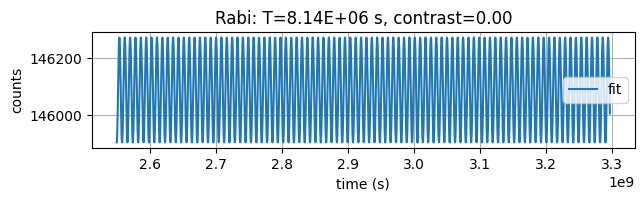

In [30]:
        # Plot & save Rabi figure
        plt.figure(figsize=(7, 1.5))
        plt.plot(result_rabi.high_res_best_fit[0], result_rabi.high_res_best_fit[1], label='fit')
        plt.title(f"Rabi: T={rabi_period:.2E} s, contrast={rabi_contrast:.2f}")
        plt.xlabel("time (s)")
        plt.ylabel("counts")
        plt.grid()
        plt.legend()
        plt.show()

In [31]:
rabi_amplitude

34.21434109722901

In [33]:
        # -- typical Lorentzian Dip params: center, amplitude, offset, sigma
        lor_amplitude = result_odmr.params['amplitude'].value
        lor_offset = result_odmr.params['offset'].value
        res_freq = result_odmr.params['center'].value

        # Lorentzian contrast = amplitude / offset
        odmr_contrast = -lor_amplitude / lor_offset if lor_offset else 0.0

In [34]:
odmr_contrast

-0.0019662002858190533

In [35]:
lor_amplitude

-287.27601597764607

In [36]:
lor_offset

146107.19876788976

In [37]:
result_odmr.params['sigma'].value

16026665.391562816

Go to POI POI_8 ...
Position and counts at peak after refocus: (8.584, 45.893, -6.369) µm,  σ= (0.218, 0.305, 0.822) µm, peak cnts: 4.29E+04
Start measurements for orientation 3 ...


 ... rabi:   0%|          | 0/10000.0 [00:00<?, ?sweeps/s]

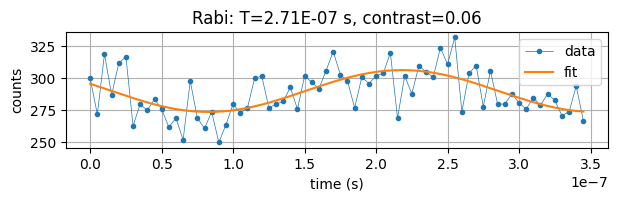

 ... pulsedODMR:   0%|          | 0/10000.0 [00:00<?, ?sweeps/s]

All POIs measured successfully.
+-------+-------------+-------------+-----------+------------+--------------+------------+--------------+
|  POI  | Orientation | StartCounts | EndCounts | RabiPeriod | RabiContrast |  ODMRFreq  | ODMRContrast |
+-------+-------------+-------------+-----------+------------+--------------+------------+--------------+
| POI_8 |      3      |  4.29E+04   | 4.29E+04  |  2.71E-07  |     0.06     | 2.8386E+09 |     0.07     |
+-------+-------------+-------------+-----------+------------+--------------+------------+--------------+


In [38]:
import datetime
import os
import time
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate  # pip install tabulate

# Root folder for results
results_root = "results"

# Create a timestamped folder name
timestamp_str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
run_folder_name = f"characterization_run_{timestamp_str}"

# Combine root + run folder
run_folder = os.path.join(results_root, run_folder_name)

# Create that folder if it doesn't already exist
os.makedirs(run_folder, exist_ok=True)

# We'll accumulate all measurement results here
all_results = []

orientation_properties = {
    1: {'res_freq': 2.605e9, 'freq_range': [2580.0e6, 1.0e6, 40],  'rabi_period': 2.73e-7},
    2: {'res_freq': 2.665e9, 'freq_range': [2640.0e6, 1.0e6, 40],  'rabi_period': 5.06e-7},
    3: {'res_freq': 2.840e9, 'freq_range': [2820.0e6, 1.0e6, 40], 'rabi_period': 2.93e-7},
    4: {'res_freq': 2.887e9, 'freq_range': [2870.0e6, 1.0e6, 40], 'rabi_period': 2.05e-7},
    5: {'res_freq': 2.900e9, 'freq_range': [2550.0e6, 2.5e6, 300], 'rabi_period': 2.05e-7},
}

poi_list = [
    {'poi': 'POI_8', 'orientations': [3]},
]

# Clear pulse generator
pulsed_master_logic.clear_pulse_generator()
time.sleep(1)

for entry in poi_list:
    currPoi = entry['poi']
    print(f"Go to POI {currPoi} ...")

    # Disable refocus/tracking, move to POI, then re-enable
    poi_manager_logic.toggle_periodic_refocus(False)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)
    poi_manager_logic.go_to_poi(currPoi)
    poi_manager_logic.set_active_poi(currPoi)
    poi_manager_logic.toggle_periodic_refocus(True)
    while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
        time.sleep(0.1)

    print("Position and counts at peak after refocus:", scanner_gui.optimizer_dockwidget.result_label.text())
    for orientation in entry['orientations']:
        print(f"Start measurements for orientation {orientation} ...")
        countsStart = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        # -------------------------
        # 1) Rabi Measurement (Sine Fit)
        # -------------------------
        confocal2.generate_params['microwave_frequency'] = orientation_properties[orientation]['res_freq']
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.rabi_sweeps = 1e4

        rabi_label = f"{currPoi}_ornt_{orientation}_Rabi"
        confocal2.do_rabi(rabi_label, isSlow=True)

        # Fit and extract results
        result_rabi = netobtain(pulsed_measurement_logic.do_fit('Sine'))
        rabi_amplitude = result_rabi.params['amplitude'].value
        rabi_offset    = result_rabi.params['offset'].value
        rabi_freq      = result_rabi.params['frequency'].value

        # Rabi period, contrast, etc.
        rabi_period = 1.0 / rabi_freq if rabi_freq != 0 else 0.0
        rabi_contrast = (rabi_amplitude / rabi_offset) if rabi_offset else 0.0

        # Grab final Rabi stats
        rabi_rsquared = result_rabi.rsquared

        # Save raw Rabi data
        tData_rabi   = netobtain(pulsed_measurement_logic.signal_data[0])
        sigData_rabi = netobtain(pulsed_measurement_logic.signal_data[1])
        rabi_data_filename = os.path.join(run_folder, f"Rabi_{currPoi}_ornt_{orientation}.txt")
        with open(rabi_data_filename, 'w') as f:
            f.write("# time (s)\tcounts\n")
            for x, y in zip(tData_rabi, sigData_rabi):
                f.write(f"{x}\t{y}\n")

        # Plot & save Rabi figure
        plt.figure(figsize=(7, 1.5))
        plt.plot(tData_rabi, sigData_rabi, 'o-', ms=3, linewidth=0.5, label='data')
        plt.plot(result_rabi.high_res_best_fit[0], result_rabi.high_res_best_fit[1], label='fit')
        plt.title(f"Rabi: T={rabi_period:.2E} s, contrast={rabi_contrast:.2f}")
        plt.xlabel("time (s)")
        plt.ylabel("counts")
        plt.grid()
        plt.legend()
        rabi_fig_path = os.path.join(run_folder, f"Rabi_{currPoi}_ornt_{orientation}.png")
        plt.savefig(rabi_fig_path, dpi=150, bbox_inches='tight')
        plt.show()

        # -------------------------
        # 2) Pulsed ODMR (Lorentzian Dip)
        # -------------------------
        confocal2.pulsedODMR_params['freq_start']    = orientation_properties[orientation]['freq_range'][0]
        confocal2.pulsedODMR_params['freq_step']     = orientation_properties[orientation]['freq_range'][1]
        confocal2.pulsedODMR_params['num_of_points'] = orientation_properties[orientation]['freq_range'][2]
        confocal2.generate_params['rabi_period'] = rabi_period
        pulsed_master_logic.set_generation_parameters(confocal2.generate_params)
        confocal2.pulsedODMR_sweeps = 1e4

        odmr_label = f"{currPoi}_ornt_{orientation}_ODMR"
        confocal2.do_pulsedODMR(odmr_label)

        result_odmr = netobtain(pulsed_measurement_logic.do_fit('Lorentzian Dip'))
        lor_center  = result_odmr.params['center'].value
        lor_amp     = result_odmr.params['amplitude'].value
        lor_offset  = result_odmr.params['offset'].value
        odmr_contrast = -lor_amp / lor_offset if lor_offset else 0.0

        # Wait for system to unlock
        while scanner_gui.module_state() == 'locked' or (scanning_optimize_logic._sequence_index < len(scanning_optimize_logic._scan_sequence)):
            time.sleep(0.1)
        countsEnd = scanner_gui.optimizer_dockwidget.result_label.text()[-9:]

        # Store in a dictionary for tabulate
        row_data = {
            "POI":           currPoi,
            "Orientation":   orientation,
            "StartCounts":   countsStart,
            "EndCounts":     countsEnd,
            "RabiPeriod":    f"{rabi_period:.2E}",
            "RabiContrast":  f"{rabi_contrast:.2f}",
            "ODMRFreq":      f"{lor_center:.4E}",
            "ODMRContrast":  f"{odmr_contrast:.2f}",
        }
        all_results.append(row_data)

print("All POIs measured successfully.")

# -----------------------------------------------------------------------------------
# FIX: Provide a dictionary mapping from your data keys to the desired column names.
# -----------------------------------------------------------------------------------
headers_map = {
    "POI":          "POI",
    "Orientation":  "Orientation",
    "StartCounts":  "StartCounts",
    "EndCounts":    "EndCounts",
    "RabiPeriod":   "RabiPeriod",
    "RabiContrast": "RabiContrast",
    "ODMRFreq":     "ODMRFreq",
    "ODMRContrast": "ODMRContrast",
}

# Now we create an ASCII table using tabulate
table_str = tabulate(all_results, headers=headers_map, tablefmt="pretty")

# Save to file in the new subfolder
summary_file_path = os.path.join(run_folder, "measurements_summary.txt")
with open(summary_file_path, 'w') as outputFile:
    outputFile.write(table_str + "\n")

# Print to console as well
print(table_str)
